## Strava Activity Analysis

### 1. Import activity data with Strava's API

In [1]:
import json
import requests
import urllib3
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import polyline

#config
import strava_config as cfg

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': cfg.secrets['client_id'],
    'client_secret': cfg.secrets['client_secret'],
    'refresh_token': cfg.secrets['refresh_token'],
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
#print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}

activities = []
page = 1
per_page = 200 #max request per page is 200
while True:
    params = {'page': page, 'per_page': per_page}
    json_dataset = requests.get(activities_url, headers=header, params=params).json()
    activities += json_dataset
    if len(json_dataset) < per_page:
        break
    page += 1

print(f"Retrieved {len(activities)} activities.")

#decode polyline into list of coordinates for each route.
polylines = [activity["map"]["summary_polyline"] for activity in activities]
coords = [polyline.decode(polyline_str) for polyline_str in polylines]


# Load the nested JSON list into a Pandas DataFrame
df = json_normalize(activities)
#print(df)
df['coords'] = coords
df['polyline'] = polylines
#select columns of interest
df = df[["name","id","gear_id","sport_type","start_date","start_date_local","distance","moving_time","elapsed_time","average_heartrate","max_heartrate","average_speed","max_speed","average_temp",
"average_watts","comment_count","start_latlng","end_latlng","achievement_count","elev_high","elev_low","total_elevation_gain","coords","trainer","polyline"]]

Requesting Token...

Access Token = 1aceacb4155cb70240711ed6bc076078a05fc759

Retrieved 273 activities.
Requesting Token...

Retrieved 273 activities.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 25 columns):
name                    273 non-null object
id                      273 non-null int64
gear_id                 147 non-null object
sport_type              273 non-null object
start_date              273 non-null object
start_date_local        273 non-null object
distance                273 non-null float64
moving_time             273 non-null int64
elapsed_time            273 non-null int64
average_heartrate       62 non-null float64
max_heartrate           62 non-null float64
average_speed           273 non-null float64
max_speed               273 non-null float64
average_temp            31 non-null float64
average_watts           248 non-null float64
comment_count           273 non-null int64
start_latlng            273 non-null object
end_latlng              273 non-null object
achievement_count       273 non-null int64
elev_high               273 non-null float64
elev_low       

In [3]:
df['sport_type'].value_counts()

Ride           239
VirtualRide     17
Run             14
Hike             3
Name: sport_type, dtype: int64

### 2. Clean data

In [4]:
# subset dataframe to include just "Ride" or "VirtualRide" activities
df = df[(df['sport_type'] == "Ride") | (df['sport_type'] == "VirtualRide")].reset_index(drop=True)

#Unit conversions
df['distance'] = df["distance"] * 0.000621371 #meters to miles
df['total_elevation_gain'] = df["total_elevation_gain"] * 3.28084 #meters to feet
df["elev_high"] = df["elev_high"] * 3.28084
df["elev_low"] = df["elev_low"] * 3.28084
df["elapsed_time"] = df["elapsed_time"]/60 #seconds to minutes
df["moving_time"] = df["moving_time"]/60
df["average_speed"] = df["average_speed"] * 2.23694 #meters/second to miles/hour
df["max_speed"] = df["max_speed"] * 2.23694

#rename cols to include units and add detail
col_map = {
    'name': 'activity_name',
    'id': 'activity_id',
    'distance': 'distance_m',
    'moving_time': 'moving_time_s',
    'elapsed_time': 'elapsed_time_s',
    'average_heartrate': 'avg_heart_rate_bpm',
    'max_heartrate': 'max_heart_rate_bpm',
    'average_speed': 'avg_speed_mph',
    'max_speed': 'max_speed_mph',
    'average_temp': 'avg_temp_celsius',
    'average_watts': 'avg_power_watts',
    'elev_high': 'elevation_high_ft',
    'elev_low': 'elevation_low_ft',
    'total_elevation_gain': 'total_elevation_gain_ft',
}

df = df.rename(columns=col_map)

#time stuff
df['activity_date'] = pd.to_datetime(df['start_date_local'])
df['start_time'] = df['activity_date'].dt.time
df['month'] = df['activity_date'].dt.month_name()
df['year'] = df['activity_date'].dt.year
df['year'] = (df['year']).astype(np.object) #change year from numeric to object
df['dayofyear'] = df['activity_date'].dt.dayofyear
df['dayofyear'] = pd.to_numeric(df['dayofyear'])
df['dayofweek'] = df['activity_date'].dt.dayofweek

#replace gear_id with gear name
df['gear_id'] = df['gear_id'].replace(['b11998419', 'b11294998', 'b11590951', 'b11671431'], ['LHT', 'Alduin', 'Grocery_machine', 'Peugeot'])

Handle NA values

In [5]:
pd.set_option('display.max_columns', 500)
#Looks like about every row has at least some NAN values, but some rows (238-250) are completely NAN. Due to import?
#df[df.isnull().any(axis=1)]

#check where distance_m is null, and drop where true
df = df[df['distance_m'].notna()]

### 3. Analyze data

In [6]:
df.describe()

,activity_id,distance_m,moving_time_s,elapsed_time_s,avg_heart_rate_bpm,max_heart_rate_bpm,avg_speed_mph,max_speed_mph,avg_temp_celsius,avg_power_watts,comment_count,achievement_count,elevation_high_ft,elevation_low_ft,total_elevation_gain_ft,dayofyear,dayofweek
count,2.560000e+02,256.000000,256.000000,256.000000,60.000000,60.000000,256.000000,256.000000,31.000000,248.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,7.628831e+09,11.914827,51.738411,136.086458,124.516667,151.900000,12.742003,28.225054,17.258065,119.344758,0.019531,13.941406,594.292127,376.708356,491.878655,150.734375,3.371094
std,1.213738e+09,17.521295,65.148544,973.572224,15.494342,16.519839,2.392777,6.258247,6.737793,23.896334,0.164524,37.118365,786.030730,768.231397,622.191614,90.552551,2.102982
min,3.836154e+09,0.644921,4.383333,4.816667,96.300000,117.000000,6.648186,14.249308,7.000000,55.400000,0.000000,0.000000,51.181104,-48.556432,32.480316,1.000000,0.000000
25%,7.170000e+09,2.791789,14.012500,19.358333,111.550000,142.250000,10.956532,23.858643,11.500000,102.750000,0.000000,0.000000,276.574812,26.164699,153.051186,78.500000,2.000000
50%,7.844222e+09,6.806498,32.916667,43.566667,125.700000,153.000000,12.551470,27.747004,18.000000,116.850000,0.000000,2.000000,283.136492,56.430448,307.414708,137.000000,4.000000
75%,8.564733e+09,15.798637,70.283333,97.054167,136.500000,166.000000,14.519978,31.737705,21.500000,134.375000,0.000000,8.250000,353.100405,177.329402,576.607630,219.000000,5.000000
max,9.179966e+09,204.917592,692.066667,15583.716667,150.700000,178.000000,19.825999,52.729150,29.000000,192.900000,2.000000,271.000000,2732.283552,2460.301916,5219.816440,360.000000,6.000000


In [7]:
df.head()

,activity_name,activity_id,gear_id,sport_type,start_date,start_date_local,distance_m,moving_time_s,elapsed_time_s,avg_heart_rate_bpm,max_heart_rate_bpm,avg_speed_mph,max_speed_mph,avg_temp_celsius,avg_power_watts,comment_count,start_latlng,end_latlng,achievement_count,elevation_high_ft,elevation_low_ft,total_elevation_gain_ft,coords,trainer,polyline,activity_date,start_time,month,year,dayofyear,dayofweek
0,Sounders,9179966085,LHT,Ride,2023-05-31T23:36:19Z,2023-05-31T16:36:19Z,9.592415,49.300000,335.650000,113.6,143.0,11.674590,34.213997,NaN,133.1,0,"[47.65460841357708, -122.35906910151243]","[47.65462936833501, -122.35918032936752]",6,169.619428,18.044620,460.958020,"[(47.6546, -122.35907), (47.65426, -122.35907)...",False,gpzaHdgyiVbA?TE\UvB?PLJCRk@PyAFaAFc@JMVOx@E|AB...,2023-05-31 16:36:19,16:36:19,May,2023,151,2
1,Evening Ride,9173153117,LHT,Ride,2023-05-31T01:47:25Z,2023-05-30T18:47:25Z,5.615205,27.950000,51.633333,107.0,134.0,12.054870,25.865737,NaN,142.8,0,"[47.65481351874769, -122.35907857306302]","[47.65460338443518, -122.35917504876852]",6,276.902896,30.183728,342.847780,"[(47.65481, -122.35908), (47.6548, -122.35906)...",False,qqzaHfgyiV@CbBBZAZQF?jA?|@DDCLWn@oEDKHITExCAJC...,2023-05-30 18:47:25,18:47:25,May,2023,150,1
2,Grocery loop,9172956427,LHT,Ride,2023-05-31T00:28:02Z,2023-05-30T17:28:02Z,2.067612,12.766667,47.066667,111.1,133.0,9.717267,17.920126,NaN,107.8,0,"[47.654700111597776, -122.35991885885596]","[47.65482257120311, -122.35920757055283]",3,105.314964,26.246720,112.860896,"[(47.6547, -122.35992), (47.65478, -122.36006)...",False,{pzaHnlyiVOZ@fBAFQG{AoHVWC{@RBP`A@hACv@IVq@v@o...,2023-05-30 17:28:02,17:28:02,May,2023,150,1
3,Afternoon Ride,9166610264,LHT,Ride,2023-05-29T22:23:18Z,2023-05-29T15:23:18Z,12.529760,65.066667,156.600000,102.2,123.0,11.553795,26.020086,NaN,108.4,0,"[47.65482382848859, -122.35946162603796]","[47.66556154936552, -122.37327684648335]",14,82.021000,11.482940,136.811028,"[(47.65482, -122.35947), (47.65483, -122.35952...",False,sqzaHtiyiVAHD`A@~BAFMDCF@VP`@fAJDFDRCx@oAfAgDl...,2023-05-29 15:23:18,15:23:18,May,2023,149,0
4,Bag secure,9160332688,LHT,Ride,2023-05-29T00:23:36Z,2023-05-28T17:23:36Z,22.680104,108.150000,128.166667,127.7,162.0,12.582788,28.310713,NaN,143.8,0,"[47.65450078994036, -122.3590082488954]","[47.654821649193764, -122.35938090831041]",50,455.708676,25.918636,1171.916048,"[(47.6545, -122.35901), (47.6543, -122.35898),...",False,sozaHxfyiVf@ErECt@}ELQxCIn@c@rGkQn@m@lAeI|FiPT...,2023-05-28 17:23:36,17:23:36,May,2023,148,6


Let's see if there are any obvious trends or patters with pairs plot

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
pp_df = df[['distance_m', 'moving_time_s', 'total_elevation_gain_ft', 'avg_speed_mph']]
sns.pairplot(pp_df)

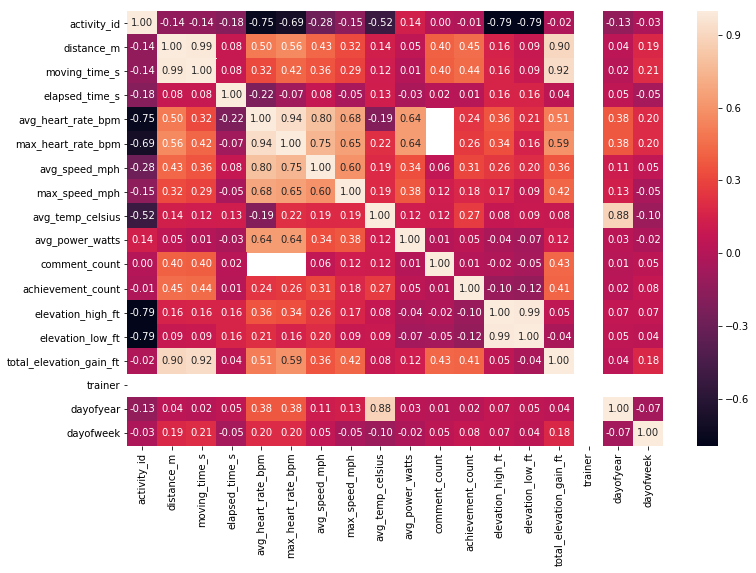

In [9]:
corr = df.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot=True, fmt=".2f");

#### Highlights
1. There are only a handful of rides > 60 miles. 
2. Seattle to Portland is visible in the top right of most plots as an outlier.
3. Average speed looks appoximately normal around 12.5 mph
4. Avg speed appears to have slightly positive correlation with distance and elevation gain and time
    - My initial hypothesis is that there are confounding factors here. I.E. elevation and speed are being studied in the dataset, group rides would be a confounder since they have a positive relationship with both elevation and speed (think route choice and drafting) 

##### More trends will likely emerge as the data is partitioned!

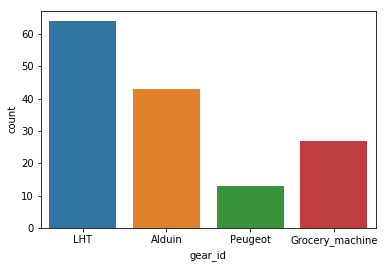

In [10]:
#gear_id was only recorded from Aug 2022 going forward
# pd.set_option('display.max_rows', 500)
# df.sort_values(by = 'start_date')
sns.countplot(x="gear_id", data=df);

I've included some virtual rides completed on my college beater bike "Peugeot".
Let's look at the propotion of IRL vs virtual rides:

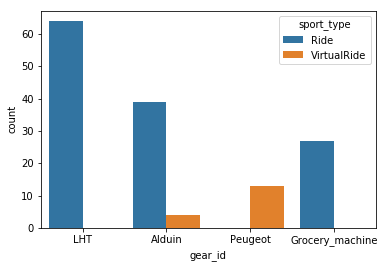

In [11]:
sns.countplot(data=df,hue='sport_type',x="gear_id")

Which months do I ride the furthest?

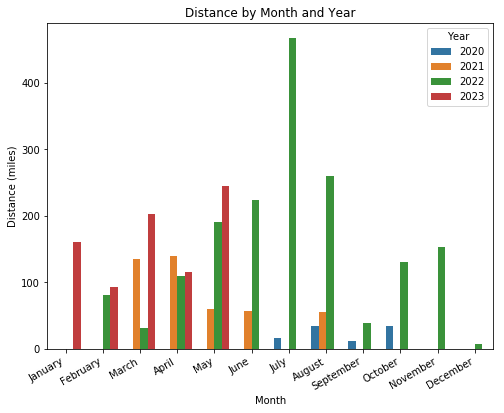

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Calculate the sum of distances by month and year
monthly_distance = df.groupby(['month', 'year'])['distance_m'].sum().reset_index()

# Convert the 'month' column to categorical with desired order
monthly_distance['month'] = pd.Categorical(monthly_distance['month'], categories=month_order, ordered=True)

# Sort the DataFrame by the categorical 'month' column
monthly_distance.sort_values('month', inplace=True)

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the bar plot using seaborn with hue='year'
ax = sns.barplot(x='month', y='distance_m', hue='year', data=monthly_distance, linewidth = 10)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Distance (miles)')
plt.title('Distance by Month and Year')

# Display the legend
plt.legend(title='Year', loc='upper right')

# Display the plot
plt.show()


* Over time I've been riding more year over year. 
* Months where I previously recorded zero miles have at least some mileage recorded.
* 2023 is shaping up to be the most consistent year so far